First step of this tutorial, we’ll use a pre-trained MTCNN model in Keras to detect faces in images. Once we’ve extracted the faces from an image, we’ll compute a similarity score between these faces to find if they belong to the same person.

First, you need to “read” images through Python before doing any processing on them. We’ll use the plotting library matplotlib to read and manipulate images.

**Step 1: Face Detection with the MTCNN Model**

The objectives in this step are as follows:


*   retrieve images hosted externally to a local server
*   read images through matplotlib‘s imread() function

*   detect and explore faces through the MTCNN algorithm
*   extract faces from an image.







1.1 Store External Images

You may often be doing an analysis from images hosted on external servers. For this example, we’ll use two images of Sundar Pichai, hosted on some random website.

To temporarily store the images locally for our analysis, we’ll retrieve each from its URL and write it to a local file.  Let’s define a function store_image for this purpose:

In [0]:
import urllib.request

In [0]:
def store_image(url, local_file_name):
  with urllib.request.urlopen(url) as resource:
    with open(local_file_name, 'wb') as f:
      f.write(resource.read())

In [0]:
store_image('https://cnet2.cbsistatic.com/img/Mk8hYn_qlH0XObzI9y8-N9QjAEM=/2017/03/08/721f9954-70ee-406b-ac3b-117e9f5e2235/sundar-pichai-google-cloud-next-2017-7696.jpg','sn1.jpg')
store_image('https://www.livemint.com/rf/Image-621x414/LiveMint/Period2/2017/05/01/Photos/Processed/Pichai-kPTF--621x414@LiveMint.jpg','sn2.jpg')

Here we have saved the image as 'sn1.jpg' and 'sn2.jpg'.

After sucessfully retrieving the images, let's detect faces in them.

1.2 Detect Faces in an Image

For this purpose, we’ll make two imports — matplotlib for reading images, and mtcnn for detecting faces within the images:

In [52]:
!pip3 install mtcnn

To use any implementation of a CNN algorithm, you need to install fastai or pytorch or keras etc.

But we are using keras for the day.

The algorithm that we’ll use for face detection is MTCNN (Multi-Task Convoluted Neural Networks), based on the paper Joint Face Detection and Alignment using Multi-task Cascaded Convolutional Networks (Zhang et al., 2016). An implementation of the MTCNN algorithm for TensorFlow in Python3.4 is available as a package. 

To compare faces after extracting them from images, we’ll use the VGGFace2 algorithm developed by the Visual Geometry Group at the University of Oxford. A TensorFlow-based Keras implementation of the VGG algorithm is available as a package for you to install:


In [53]:
!pip3 install keras_vggface

In [0]:
from matplotlib import pyplot as plt
from mtcnn.mtcnn import MTCNN

Use the imread() function to read an image:

In [0]:
image=plt.imread('sn1.jpg')

Next, initialize an MTCNN() object into the detector variable and use the .detect_faces() method to detect the faces in an image. Let’s see what it returns:

In [56]:
detector = MTCNN()
faces = detector.detect_faces(image)
for face in faces:
    print(face)

{'box': [1530, 249, 452, 634], 'confidence': 0.9999998807907104, 'keypoints': {'left_eye': (1722, 466), 'right_eye': (1937, 473), 'nose': (1885, 568), 'mouth_left': (1742, 714), 'mouth_right': (1930, 716)}}


For every face, a Python dictionary is returned, which contains three keys. The box key contains the boundary of the face within the image. It has four values: x- and y- coordinates of the top left vertex, width, and height of the rectangle containing the face. The other keys are confidence and keypoints. The keypoints key contains a dictionary containing the features of a face that were detected, along with their coordinates:

1.3 Highlight Faces in an Image

Now that we’ve successfully detected a face, let’s draw a rectangle over it to highlight the face within the image to verify if the detection was correct.

To draw a rectangle, import the Rectangle object from matplotlib.patches:

In [0]:
from matplotlib.patches import Rectangle

Let’s define a function highlight_faces to first display the image and then draw rectangles over faces that were detected. First, read the image through imread() and plot it through imshow(). For each face that was detected, draw a rectangle using the Rectangle() class.

Finally, display the image and the rectangles using the .show() method. If you’re using Jupyter notebooks, you may use the %matplotlib inline magic command to show plots inline:

In [0]:
def highlight_faces(image_path, faces):
  # display image
    image = plt.imread(image_path)
    plt.imshow(image)

    ax = plt.gca()

    # for each face, draw a rectangle based on coordinates
    for face in faces:
        x, y, width, height = face['box']
        face_border = Rectangle((x, y), width, height,
                          fill=False, color='red')
        ax.add_patch(face_border)
    plt.show()

Let’s now display the image and the detected face using the highlight_faces() function:

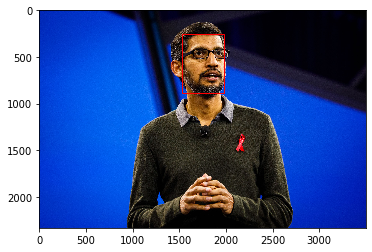

In [59]:
highlight_faces('sn1.jpg', faces)

Let’s display the second image and the face(s) detected in it:

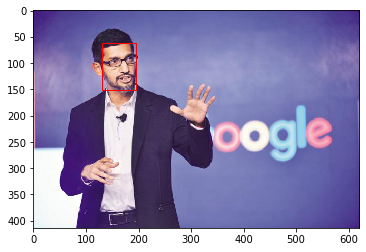

In [60]:
image = plt.imread('sn2.jpg')
faces = detector.detect_faces(image)
highlight_faces('sn2.jpg', faces)

In these two images, you can see that the MTCNN algorithm correctly detects faces. Let’s now extract this face from the image to perform further analysis on it.

**1.4 Extract Face for Further Analysis**

At this point, you know the coordinates of the faces from the detector. Extracting the faces is a fairly easy task using list indices. However, the VGGFace2 algorithm that we use needs the faces to be resized to 224 x 224 pixels. We’ll use the PIL library to resize the images.

The function extract_face_from_image() extracts all faces from an image:

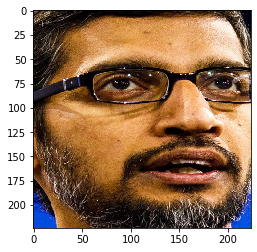

In [61]:
from numpy import asarray
from PIL import Image

def extract_face_from_image(image_path, required_size=(224, 224)):
  # load image and detect faces
    image = plt.imread(image_path)
    detector = MTCNN()
    faces = detector.detect_faces(image)

    face_images = []

    for face in faces:
        # extract the bounding box from the requested face
        x1, y1, width, height = face['box']
        x2, y2 = x1 + width, y1 + height

        # extract the face
        face_boundary = image[y1:y2, x1:x2]

        # resize pixels to the model size
        face_image = Image.fromarray(face_boundary)
        face_image = face_image.resize(required_size)
        face_array = asarray(face_image)
        face_images.append(face_array)

    return face_images

extracted_face = extract_face_from_image('sn1.jpg')

# Display the first face from the extracted faces
plt.imshow(extracted_face[0])
plt.show()

Step 2: Face Recognition with VGGFace2 Model

In this section, let’s first test the model on the two images of Lee Iacocca that we’ve retrieved. Then, we’ll move on to compare faces from images of the starting eleven of the Chelsea football team in 2018 and 2019. You’ll then be able to assess if the algorithm identifies faces of common players between the images.

**2.1 Compare Two Faces**

In this section, you need to import three modules: VGGFace to prepare the extracted faces to be used in the face recognition models, and the cosine function from SciPy to compute the distance between two faces:

In [0]:
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
from scipy.spatial.distance import cosine

Let’s define a function that takes the extracted faces as inputs and returns the computed model scores. The model returns a vector, which represents the features of a face:

In [0]:
def get_model_scores(faces):
    samples = asarray(faces, 'float32')

    # prepare the data for the model
    samples = preprocess_input(samples, version=2)

    # create a vggface model object
    model = VGGFace(model='resnet50',
      include_top=False,
      input_shape=(224, 224, 3),
      pooling='avg')

    # perform prediction
    return model.predict(samples)

faces = [extract_face_from_image(image_path)
         for image_path in ['sn1.jpg', 'sn2.jpg']]

model_scores = get_model_scores(faces[0])

In [64]:
model_scores[0][0]

0.33523303

Since the model scores for each face are vectors, we need to find the similarity between the scores of two faces. We can typically use a Euclidean or Cosine function to calculate the similarity.

Vector representation of faces are suited to the cosine similarity. Here’s a detailed comparison between cosine and Euclidean distances with an example.

The cosine() function computes the cosine distance between two vectors. The lower this number, the better match your faces are. In our case, we’ll put the threshold at 0.4 distance. This threshold is debatable and would vary with your use case. You should set this threshold based on case studies on your dataset:

In [65]:
if cosine(model_scores[0][0], model_scores[0][1]) <= 0.4:
  print("Faces Matched")

Faces Matched


In this case, the two faces of Sundar Pichai matched.

2.2 Compare Multiple Faces in Two Images

Let’s put the model to good use in this section of the tutorial. We’ll compare the faces in two images of starting elevens of the Chelsea Football Club in a Europa League match vs Slavia Prague in the 2018–19 season and the UEFA Super Cup match vs Liverpool in the 2019–20 season. While many of the players feature in both match day squads, let’s see if the algorithm is able to detect all common players.

First, let’s retrieve the resources from the URLs, detect the faces in each image and highlight them:

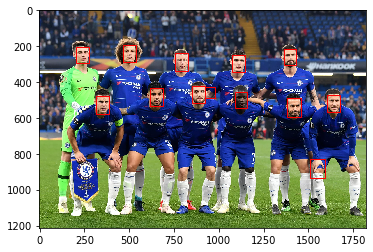

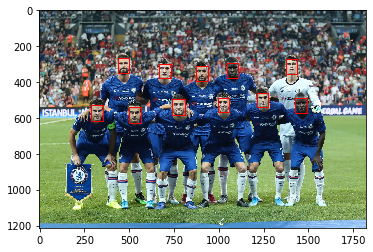

In [66]:
store_image('https://cdn.vox-cdn.com/thumbor/Ua2BXGAhneJHLQmLvj-ZzILK-Xs=/0x0:4872x3160/1820x1213/filters:focal(1877x860:2655x1638):format(webp)/cdn.vox-cdn.com/uploads/chorus_image/image/63613936/1143553317.jpg.5.jpg',
            'chelsea_1.jpg')

image = plt.imread('chelsea_1.jpg')
faces_staring_xi = detector.detect_faces(image)

highlight_faces('chelsea_1.jpg', faces_staring_xi)

store_image('https://cdn.vox-cdn.com/thumbor/mT3JHQtZIyInU8_uGxVH-TCbF50=/0x415:5000x2794/1820x1213/filters:focal(1878x1176:2678x1976):format(webp)/cdn.vox-cdn.com/uploads/chorus_image/image/65171515/1161847141.jpg.0.jpg',
            'chelsea_2.jpg')

image = plt.imread('chelsea_2.jpg')
faces = detector.detect_faces(image)

highlight_faces('chelsea_2.jpg', faces)

Before we proceed further, here are the starting elevens from both matches:

**Slavia Prague Match Starting XI**: Kepa, Azpilicueta, Luiz, Christensen, Emerson, Kante, Barkley, Kovacic, Hazard, Pedro, Giroud

**Liverpool Match Starting XI**: Kepa, Azpilicueta, Christensen, Zouma, Emerson, Kante, Jorginho, Kovacic, Pedro, Giroud, Pulisic

We have eight players who are common to both starting XIs and who ideally should be matched by the algorithm.

Let’s first compute scores:

0 2 0.16468673944473267


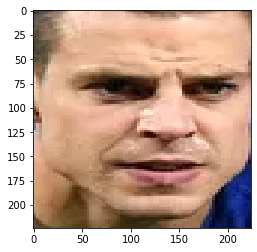

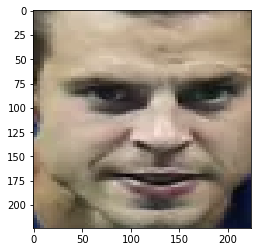

1 3 0.20797711610794067


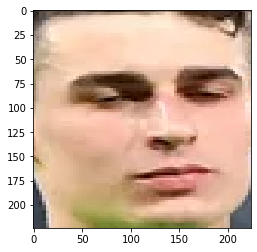

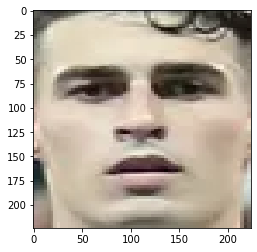

2 0 0.13851827383041382


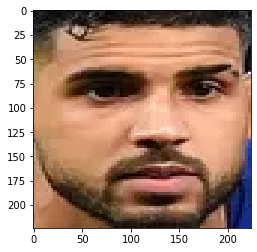

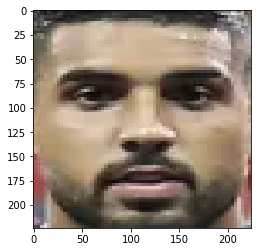

4 7 0.13456422090530396


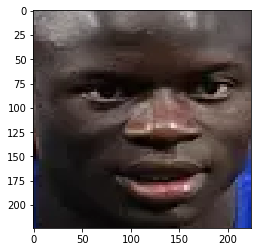

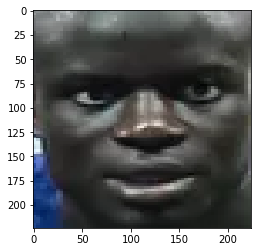

5 9 0.12841981649398804


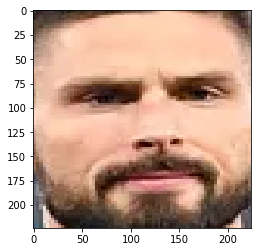

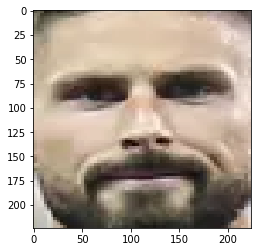

6 1 0.21432679891586304


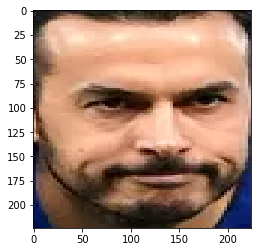

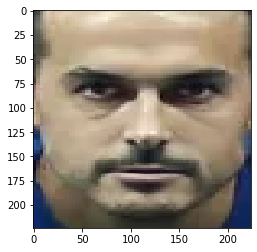

7 6 0.2473260760307312


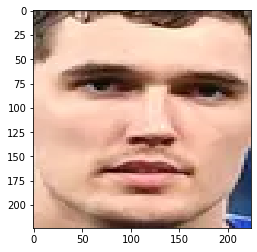

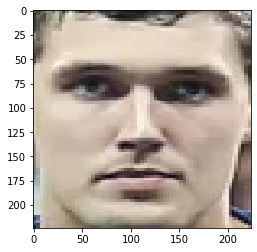

8 10 0.15307700634002686


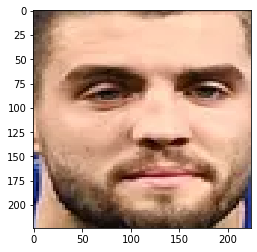

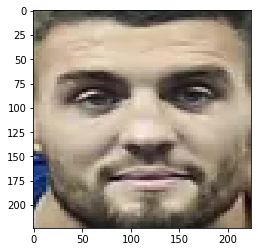

In [67]:
slavia_faces = extract_face_from_image('chelsea_1.jpg')
liverpool_faces = extract_face_from_image('chelsea_2.jpg')

model_scores_starting_xi_slavia = get_model_scores(slavia_faces)
model_scores_starting_xi_liverpool = get_model_scores(liverpool_faces)
for idx, face_score_1 in enumerate(model_scores_starting_xi_slavia):
  for idy, face_score_2 in enumerate(model_scores_starting_xi_liverpool):
    score = cosine(face_score_1, face_score_2)
    if score <= 0.4:
      # Printing the IDs of faces and score
      print(idx, idy, score)
      # Displaying each matched pair of faces
      plt.imshow(slavia_faces[idx])
      plt.show()
      plt.imshow(liverpool_faces[idy])
      plt.show()

Here’s the list of pairs of faces that the algorithm matched. Notice that it has been able to match all eight pairs of faces.
Eight Correctly Recognized Faces (Kepa, Azpilicueta, Emerson, Giroud, Kante, Pedro, Christensen, Kovacic)



While we were successfully able to match each face in our images, I’d like to take a step back to discuss ramifications of the scores. As discussed earlier, there’s no universal threshold that would match two images together. You may need to re-define these thresholds with new data coming into the analysis. For instance, even Google Photos takes your inputs when it’s unable to programmatically determine the best threshold for a pair.

The best way forward is to carefully assess cases when matching different types of faces. Emotions of the faces and their angles play a role in determining the precision too. In our use case, notice how I have deliberately used photos of starting elevens as players are staring right into the camera! You can try matching the starting eleven faces with those of a trophy celebration and I’m pretty sure the accuracy would drop.

Conclusion

In this tutorial, we first detected faces in images using the MTCNN model and highlighted them in the images to determine if the model worked correctly. Next, we used the VGGFace2 algorithm to extract features from faces in the form of a vector and matched different faces to group them together.

Do use all different algorithm to detect and match faces and try to find which is suitable for your use case as a task.

**Coding, Practicing and Learning forever!**
Notebook by - **Bhargava**